# Introduction

In [ ]:
# Installing additional libraries for text preprocessing
!pip install emoji
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=891891b33b04b3c642e1823120c660eca33642bff943a83b4c1d7889a66c438d
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.0 MB/s eta 0:00:00


In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import json
from pprint import pprint

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Text processing libraries
import emoji
import re
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing raw comments and labels
df_train = pd.read_csv('/content/drive/MyDrive/Go_Emotions/data/train.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)
df_val = pd.read_csv('/content/drive/MyDrive/Go_Emotions/data/dev.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)
df_test = pd.read_csv('/content/drive/MyDrive/Go_Emotions/data/test.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)

# Preview of data
display(df_train.head())

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
# Defining the number of samples in train, validation and test dataset
size_train = df_train.shape[0]
size_val = df_val.shape[0]
size_test = df_test.shape[0]

# Defining the total number of samples
size_all = size_train + size_val + size_test

In [ ]:
# Shape of train, validation and test datasets
print("Train dataset has {} samples and represents {:.2f}% of overall data".format(size_train, size_train/size_all*100))
print("Validation dataset has {} samples and represents {:.2f}% of overall data".format(size_val, size_val/size_all*100))
print("Test dataset has {} samples and represents {:.2f}% of overall data".format(size_test, size_test/size_all*100))
print()
print("The total number of samples is : {}".format(size_all))

Train dataset has 43410 samples and represents 80.00% of overall data
Validation dataset has 5426 samples and represents 10.00% of overall data
Test dataset has 5427 samples and represents 10.00% of overall data

The total number of samples is : 54263


In [ ]:
# Display some useful information about our data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        43410 non-null  object
 1   GE_indices  43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


In [ ]:
# Loading emotion labels for GoEmotions taxonomy
with open("/content/drive/MyDrive/Go_Emotions/data/emotions.txt", "r", encoding="utf-8") as file:
    GE_taxonomy = file.read().split("\n")

for emo in GE_taxonomy:
  print(emo)

admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral


In [ ]:
# Number of emotions
print("We have {} emotions in GoEmotions taxonomy including 'Neutral'".format(len(GE_taxonomy)))

We have 28 emotions in GoEmotions taxonomy including 'Neutral'


In [ ]:
# Concatenating the 3 datasets for labels preprocessing
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

# Preview of data
display(df_all.head(3))

print(df_all.shape)

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2


(54263, 2)


In [ ]:
# Convertings emotion indices into list of indices
df_all['GE_indices'] = df_all['GE_indices'].apply(lambda x: x.split(','))

# Preview of data
display(df_all.head(3))

,Text,GE_indices
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]


In [ ]:
# Defining a function that maps each index to emotion labels
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(GE_taxonomy[int(i)])
    return arr

# Applying the function
df_all['GE_labels'] = df_all['GE_indices'].apply(idx2class)

# Preview of data
display(df_all.head(3))

,Text,GE_indices,GE_labels
0,My favourite food is anything I didn't have to...,[27],[neutral]
1,"Now if he does off himself, everyone will thin...",[27],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],[anger]


In [ ]:
# OneHot encoding for multi-label classification
for emo in GE_taxonomy:
    df_all[emo] = np.zeros((len(df_all),1))
    df_all[emo] = df_all['GE_labels'].apply(lambda x: 1 if emo in x else 0)

# Preview of data   
display(df_all.head(3))

,Text,GE_indices,GE_labels,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,[27],[neutral],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],[neutral],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],[anger],0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Keeping only necessary columns
df_all = df_all.drop(['GE_indices','GE_labels'], axis=1)

# Preview of data   
display(df_all.head(3))

,Text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Visualising a random text sample from our dataset
text_sample = np.random.randint(len(df_all))
print(df_all.loc[text_sample, "Text"])

No. You have to have killed her due to negligence or the like. Manslaughter is essentially the crime of accidentally killing someone because you did something careless.


In [ ]:
# Building a preprocessing function to clean text
def preprocess_corpus(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)
  
  # Demojize
  x = emoji.demojize(x)
  
  # Expand contraction
  x = contractions.fix(x)
  
  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations  
  x = re.sub(r"lmao", "laughing my ass off", x)
  x = re.sub(r"lol", "laugh out loud", x)  
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x)
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)
  
  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)
  x = x.strip()

  return x

In [ ]:
# Applying the preprocessing function on the dataset
df_all["Clean_text"] = df_all["Text"].apply(preprocess_corpus)

# Preview of data
display(df_all[['Text', 'Clean_text']].sample(5))

,Text,Clean_text
30289,No actually my therapist is amazing! I've just...,no actually my therapist is amazing ! i have j...
9270,As someone who has lived his entire life in th...,as someone who has lived his entire life in th...
16617,"I speak so slowly, and i sometimes take break ...",i speak so slowly and i sometimes take break b...
21053,I see (thru) what you did there.,i see thru what you did there
38336,I like Brown Sugar,i like brown sugar


In [ ]:
# Dropping raw text column
df_all = df_all[ ['Clean_text'] + [ col for col in df_all.columns if col not in ['Text', 'Clean_text'] ] ]

# Preview of data   
display(df_all.head(3))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Building a function that will divide in train, validation and test sets
def get_train_val_test(df):
    train = df.iloc[:size_train, :]
    val = df.iloc[size_train:size_train+size_val, :]
    test = df.iloc[size_train+size_val:size_train+size_val+size_test, :]
    return train, val, test

In [ ]:
# Dividing back in train, validation and test datasets (GoEmotions)
train_GE, val_GE, test_GE = get_train_val_test(df_all)
print(train_GE.shape)
print(val_GE.shape)
print(test_GE.shape)

(43410, 29)
(5426, 29)
(5427, 29)


In [ ]:
# Preview of data   
display(train_GE.head(6))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dirty southern wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,omg peyton is not good enough to help us in th...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Computing the number of labels for each sample
train_GE['Cardinality'] = train_GE.loc[:,GE_taxonomy].apply(lambda x: sum(x), axis=1)

# Preview of data
display(train_GE.head(3))

<ipython-input-23-405298aea2b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_GE['Cardinality'] = train_GE.loc[:,GE_taxonomy].apply(lambda x: sum(x), axis=1)


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Possible number of emotions per sample in our dataset
train_GE['Cardinality'].value_counts()

1    36308
2     6541
3      532
4       28
5        1
Name: Cardinality, dtype: int64

We can see that the cardinality varies from 1 to 5 emotions per sample, with a large majority of samples that have only 1 or 2 emotions.

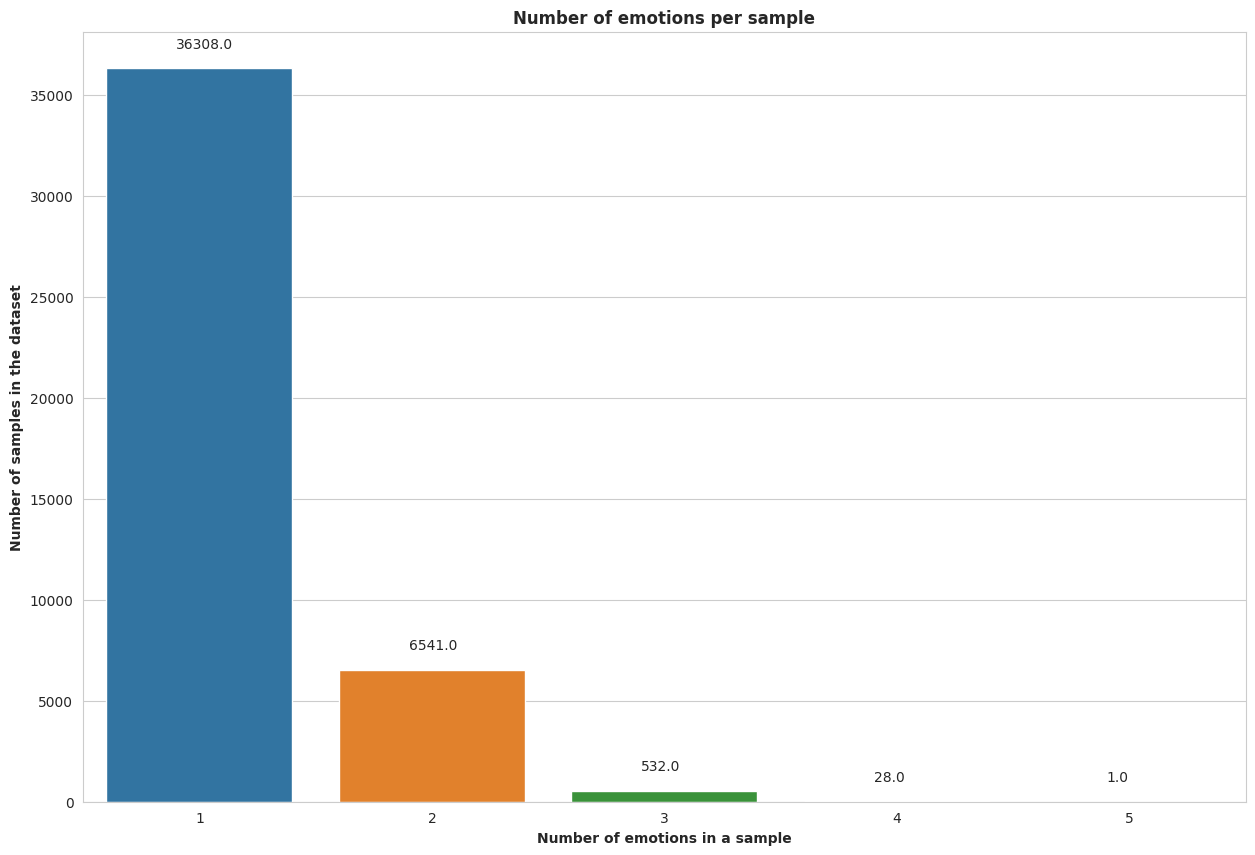

In [ ]:
# Cardinality of GoEmotions and Ekman labels across the dataset
plt.figure(figsize=(15,10))

ax = sns.countplot(x='Cardinality', data=train_GE)

for p in ax.patches:
  value = p.get_height()
  x = p.get_x() + p.get_width() - 0.5
  y = p.get_y() + p.get_height() + 1000
  ax.annotate(value, (x, y))


plt.title("Number of emotions per sample", fontweight='bold')
plt.ylabel("Number of samples in the dataset", fontweight='bold')
plt.xlabel("Number of emotions in a sample", fontweight='bold')
plt.show()

In [ ]:
# Computing number of samples per emotion
classes_GE_count = train_GE.loc[:,GE_taxonomy].sum(axis=0).sort_values(ascending=False)

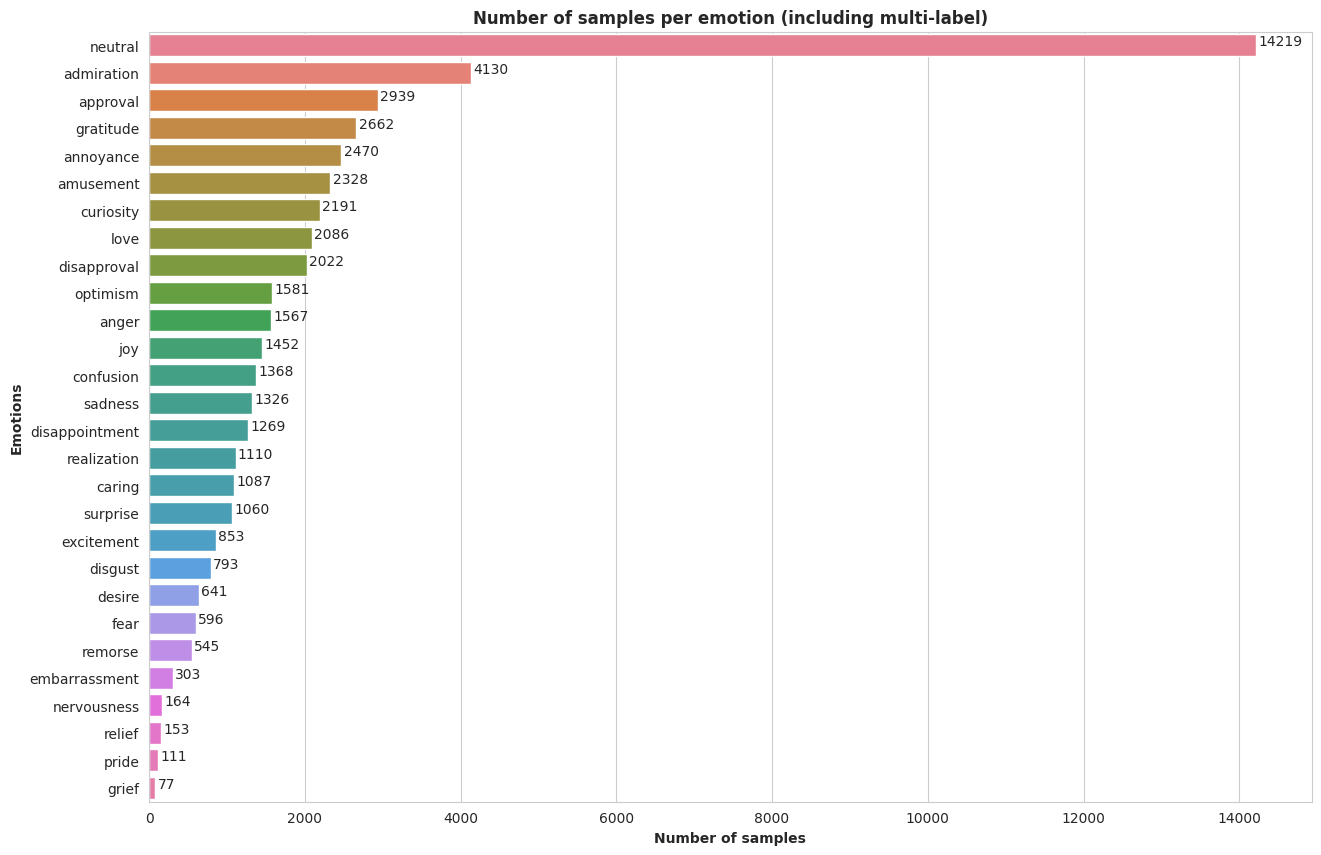

In [ ]:
# Visualizing the number of samples per classes
plt.figure(figsize=(15,10))
ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="husl")

for p in ax.patches:
  value = int(p.get_width())
  x = p.get_x() + p.get_width() + 30
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("Number of samples per emotion (including multi-label)", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Number of samples", fontweight='bold')
plt.show()

In [ ]:
# Defining classes representation for each dataset (GoEmotions)
train_count_GE = (train_GE.loc[:, GE_taxonomy].sum(axis=0) / size_train)*100
val_count_GE = (val_GE.loc[:, GE_taxonomy].sum(axis=0) / size_val)*100
test_count_GE = (test_GE.loc[:, GE_taxonomy].sum(axis=0) / size_test)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, val_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation', 'Test'], value_name='Percentage')

# Preview of data
display(balance_GE.head())

,Emotion,Dataset,Percentage
0,neutral,Train,32.755126
1,admiration,Train,9.513937
2,approval,Train,6.770329
3,gratitude,Train,6.132228
4,annoyance,Train,5.689933


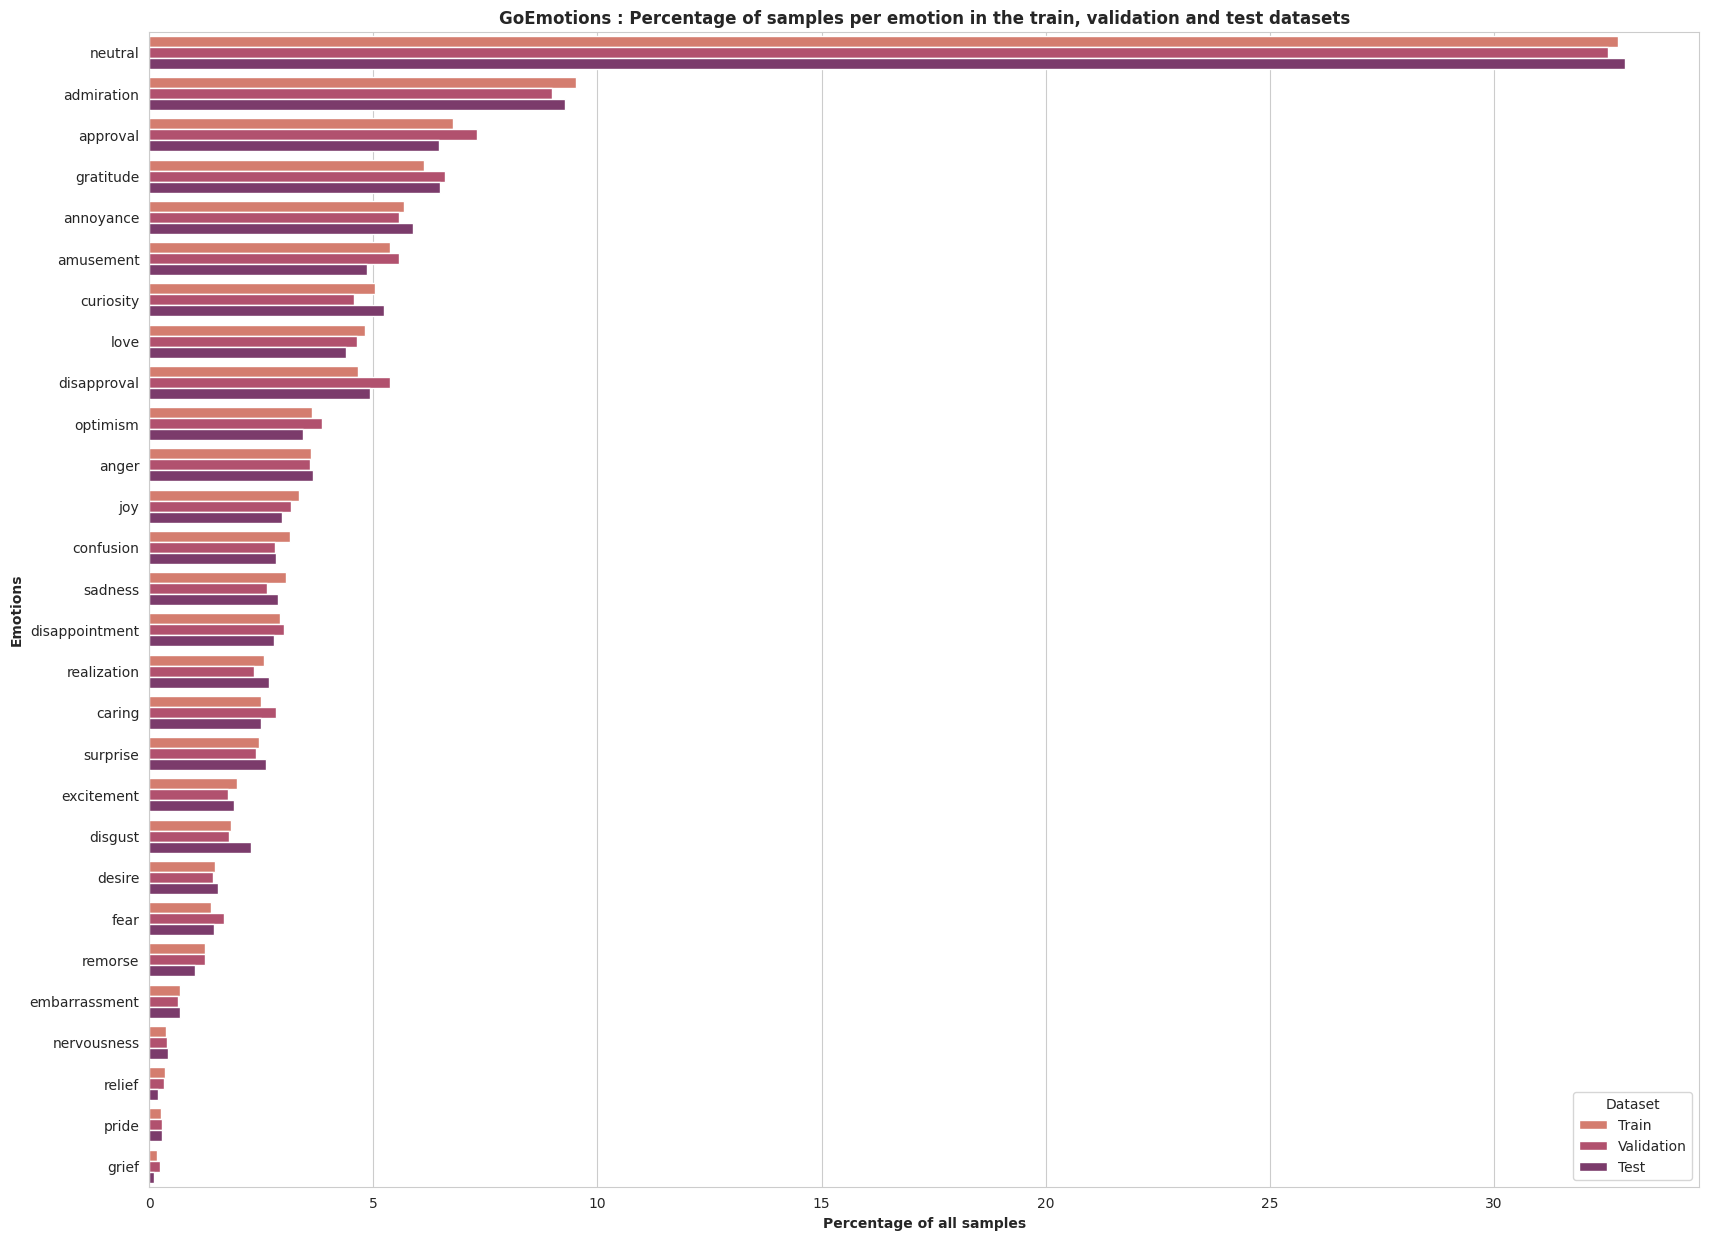

In [ ]:
# Classe Balance visualization on GoEmotions
plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="flare")
plt.title("GoEmotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

In [ ]:
# Computing the number of words per sample
train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))

# Preview of data
display(train_GE.head(3))

<ipython-input-30-7f122bdbbb0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality,Nb_words
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,12
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,20
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6


In [ ]:
# Computing the mean number of words per emotion
mean_nb_words = {}
for emo in GE_taxonomy:
  nb = train_GE['Nb_words'].loc[train_GE[emo]==1].mean()
  mean_nb_words[emo] = round(nb,2)

# Putting it in a Dataframe
df_length_GE = pd.DataFrame.from_dict(mean_nb_words, orient='index')
df_length_GE.columns = ['Mean_length']
df_length_GE.sort_values('Mean_length', ascending=False, inplace=True)

df_length_GE.head(28)

,Mean_length
optimism,16.40
realization,15.98
confusion,15.80
desire,15.30
disappointment,15.16
embarrassment,15.09
nervousness,15.08
caring,14.97
disapproval,14.91
remorse,14.79


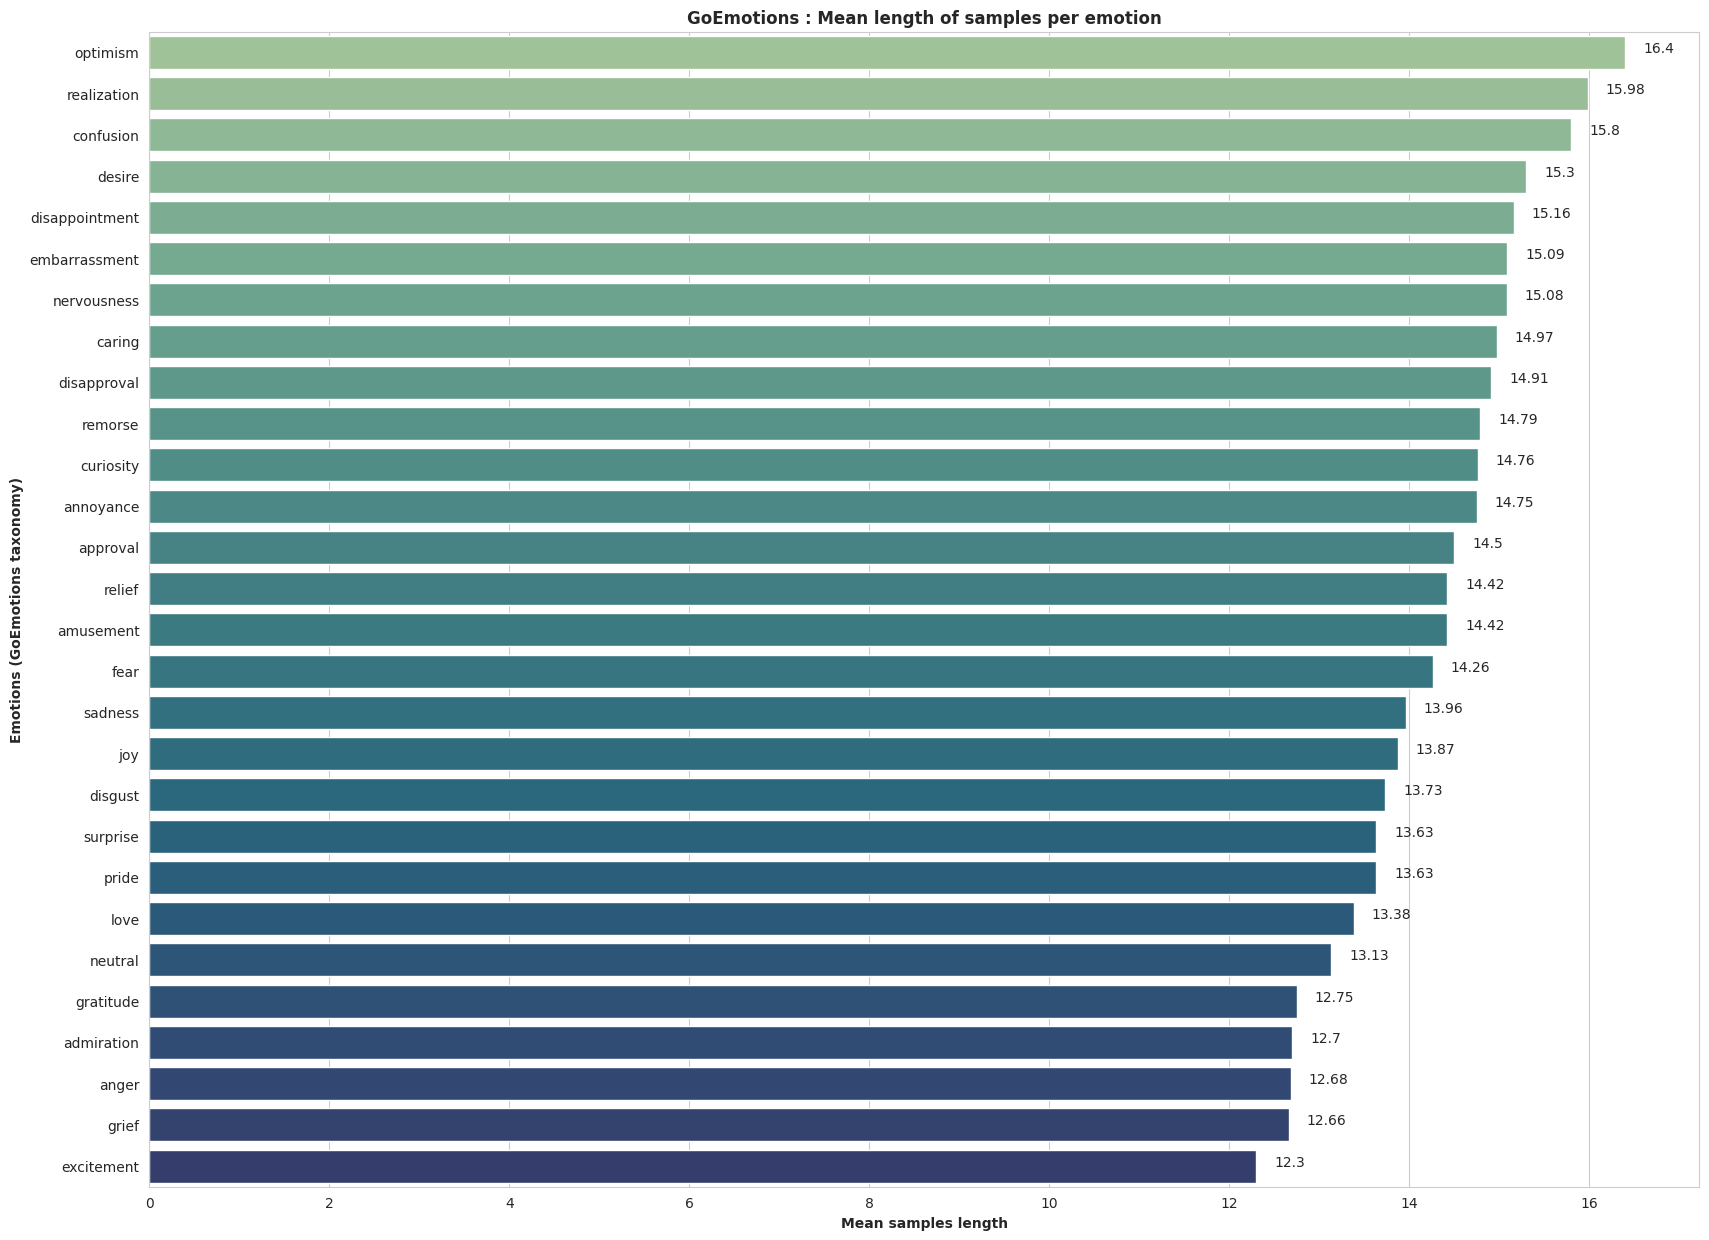

In [ ]:
# Visualizing the mean length of samples per emotion
plt.figure(figsize=(20,15))

ax = sns.barplot(x=df_length_GE['Mean_length'], y=df_length_GE.index, orient='h', palette="crest")
for p in ax.patches:
  value = p.get_width()
  x = p.get_x() + p.get_width() + 0.2
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Mean length of samples per emotion", fontweight='bold')
plt.ylabel("Emotions (GoEmotions taxonomy)", fontweight='bold')
plt.xlabel("Mean samples length", fontweight='bold')
plt.show()

# As we can see from the plot, there is not much relation between the lengths of sentences anbd their assosciated emotions.

In [ ]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart(comments, axes):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(10) # retrieve the 10 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:10]:
      x.append(word)
      y.append(count)       
    sns.barplot(x=y, y=x , ax=axes, palette="Paired")

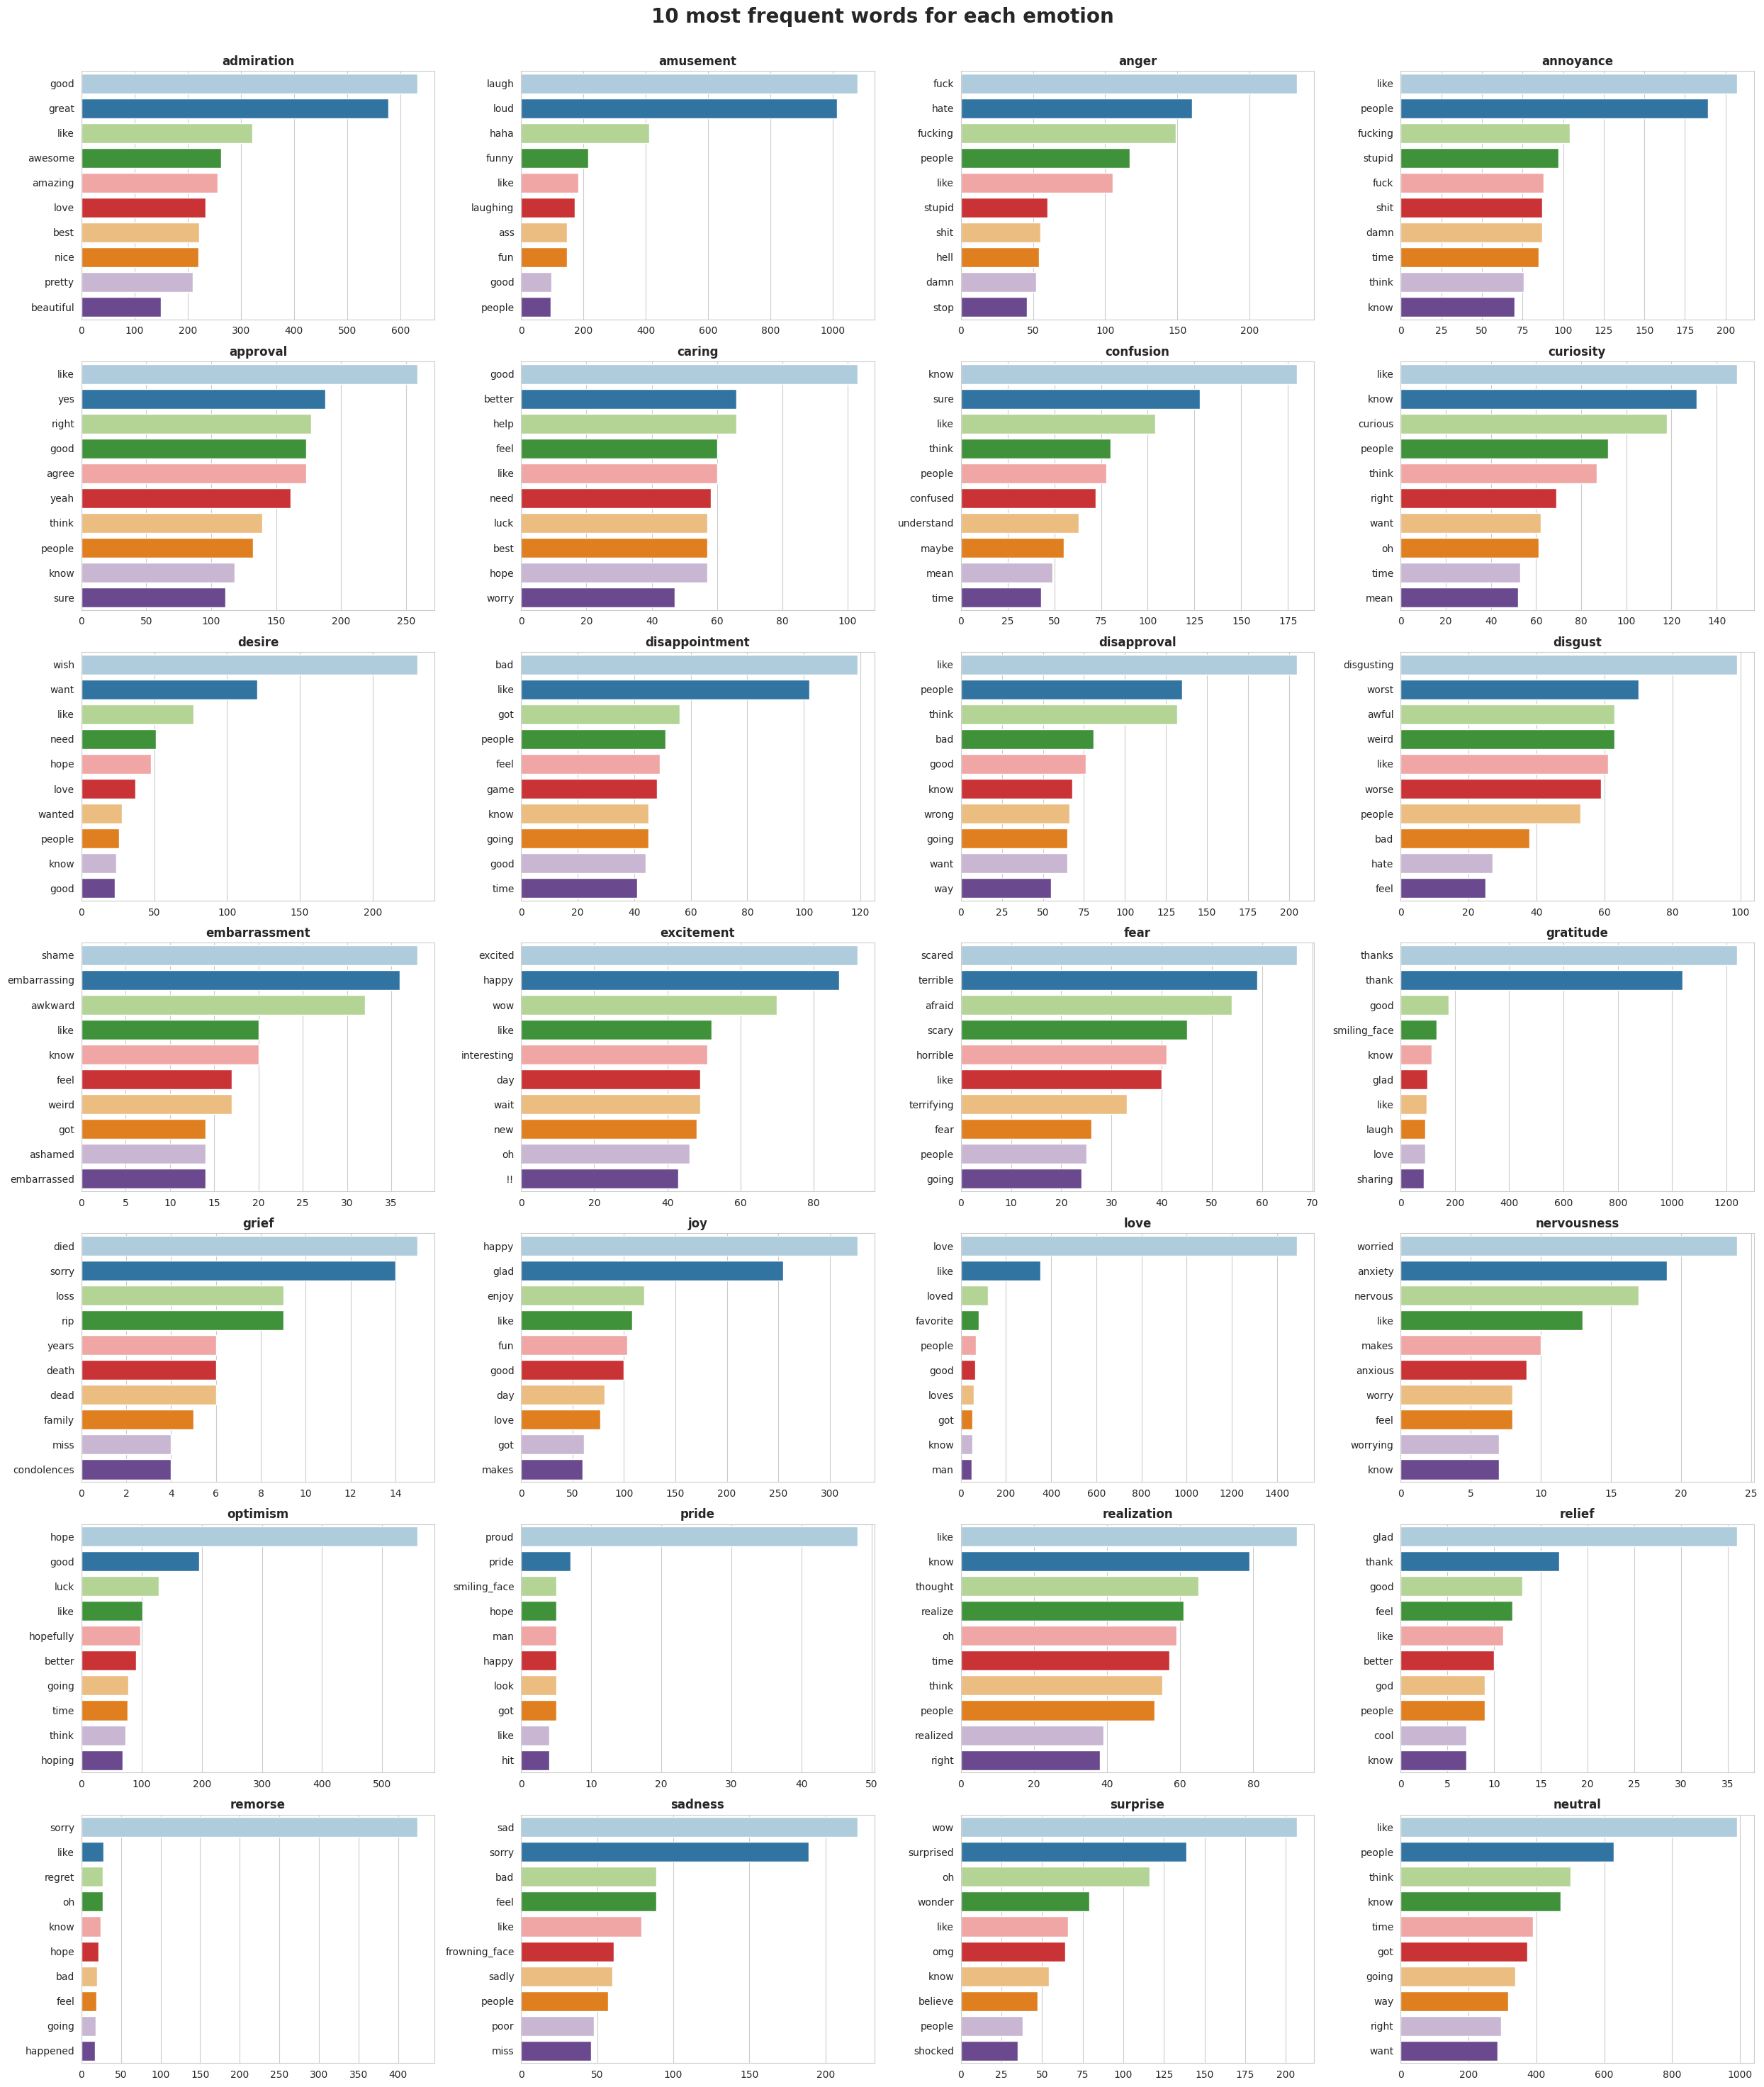

In [ ]:
# Displaying 10 most frequent words for each emotion
fig, axes = plt.subplots(7, 4, figsize=(25, 30))
fig.suptitle('10 most frequent words for each emotion', fontweight="bold", fontsize=20)

for i, axi in enumerate(axes.flat):
    plot_top_words_barchart(train_GE.loc[train_GE[GE_taxonomy[i]]==1,"Clean_text"], axi)
    axi.set_title(GE_taxonomy[i], fontweight="bold")

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# We can see the that the top words are mostly representative of the detected emotions.

Save the clean datasets in our drive for future use.

In [ ]:
# Droping unecessary columns
train_GE = train_GE[ ['Clean_text'] + GE_taxonomy ]

# Saving datasets for modeling
train_GE.to_csv("/content/drive/MyDrive/Go_Emotions/data/train_clean.csv", index = False)
val_GE.to_csv("/content/drive/MyDrive/Go_Emotions/data/val_clean.csv", index = False)
test_GE.to_csv("/content/drive/MyDrive/Go_Emotions/data/test_clean.csv", index = False)